In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from xgboost import plot_importance

# Phase 3 - stock volatility modeling

3 ML-based volatility models - LSTM, GRU, XGBoost
then evaluate them with different metrics such as MSE, RMSE, Log-likelihood, etc.

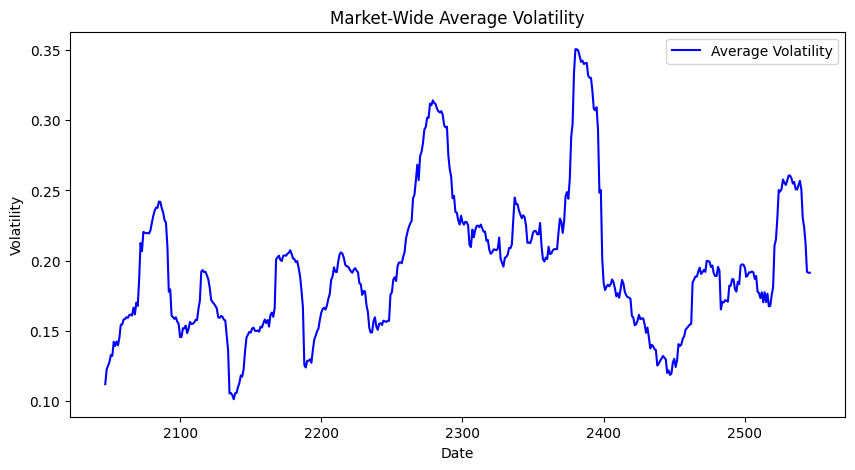

      volatility
2047    0.112177
2048    0.122700
2049    0.125263
2050    0.128067
2051    0.132947
...          ...
2542    0.223830
2543    0.212225
2544    0.192045
2545    0.191438
2546    0.191474

[500 rows x 1 columns]


In [ ]:
# gather data
stockgrp = pd.read_excel("10yrClosingPricesStocks.xlsx")
stockgrp = stockgrp.drop(columns=['Date'])

#volatility stuff
returns = np.log(stockgrp / stockgrp.shift(1))
volatility = returns.rolling(window=20).std() * np.sqrt(252)
volatility = volatility.dropna()

#we will work with the average of our 18 stocks to fit a marketwide view
avg_volatility = volatility.mean(axis=1) 
avg_volatility = avg_volatility.to_frame()
avg_volatility.columns = ['volatility']

def plot_avg(data):
    plt.figure(figsize=(10,5))
    plt.plot(data, label="Average Volatility", color="blue")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.title("Market-Wide Average Volatility")
    plt.legend()
    plt.show()
plot_avg(avg_volatility.tail(500))

In [4]:
#Set up train and test data for LSTM and GRU models
train_size = int(len(avg_volatility) * 0.8)
train_data = avg_volatility[:train_size]
test_data = avg_volatility[train_size:]
train_data = train_data.values
test_data = test_data.values

# Initialize scalers
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data only
scaled_train_data = scaler.fit_transform(train_data.reshape(-1, 1))

# Transform the testing data using the same scaler
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))

#create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30 #number of days to look back in a sequence - adjust this as needed
X_train, y_train = create_sequences(scaled_train_data, sequence_length)
X_test, y_test = create_sequences(scaled_test_data, sequence_length)

# Reshape X to include the feature dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
#build actual LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

#add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Train model
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

#Predict 
predictions = model.predict(X_test)


Epoch 1/50


c:\Users\Jack Klug\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0085 - val_loss: 5.4748e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 4.6140e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.3890e-04 - val_loss: 4.6193e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 2.6768e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7935e-04 - val_loss: 2.4472e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.0183e-04 - val_loss: 4.5820e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.1778e-04 - val_loss: 2.6924e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0656e-04 - val_loss: 3.2518e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.4822e-04 - val_loss: 2.3562e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.0976e-04 - val_loss: 3.1192e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7461e-04 - val_loss: 2.2168e-0

RMSE: 0.010197324664037565
MAE: 0.0070766773455938565
R²: 0.957698422137098


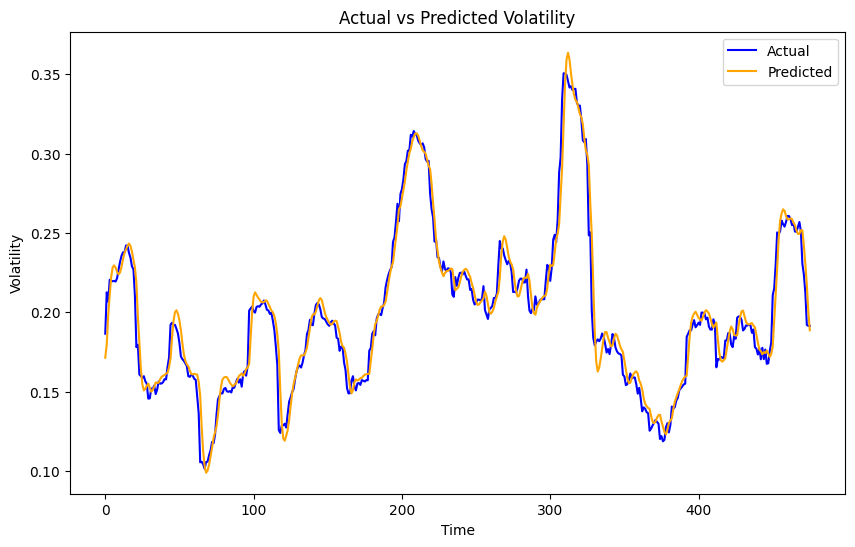

In [15]:
#Evaluate LSTM Model
# this inverses the scaling from earlier
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions = scaler.inverse_transform(predictions) #rescale back to original values

#key metrics first
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test_original, predictions)
print(f"MAE: {mae}")
r2 = r2_score(y_test_original, predictions)
print(f"R²: {r2}")

#Now visualize the model output/predictions
#actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('Actual vs Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## Summary of LSTM
Long short-term memory is a type of recurrent neural network especially good at handling time series data. It uses memory cells and gates to decide what information to keep, update, or forget. 

Let's look at how our model did:
- Above we have an excellent example of LSTM being used on our 18 stock dataset that basically perfectly predicts the volatility of our averaged stocks.
-  We can also see that our mean squared error and mean absolute error come out to less than .01, which is exceptional. 
- For the R^2 we were off of 1 by less than .05 meaning it was nearly a perfect fit to the actual data.
- Finally, we can then see all of these represented in our graph above showing almost the same graph for the actual and predicted volatilities

Now, let's try out the GRU model

In [7]:
#GRU model - we can use data from before and plug into model
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the GRU model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the GRU model
history = gru_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
gru_predictions = gru_model.predict(X_test)

Epoch 1/50


c:\Users\Jack Klug\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0053 - val_loss: 2.8700e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5273e-04 - val_loss: 2.9376e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.8236e-04 - val_loss: 1.8159e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.7454e-04 - val_loss: 2.0260e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.7872e-04 - val_loss: 1.9962e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.7351e-04 - val_loss: 1.5724e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.6858e-04 - val_loss: 1.1446e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5910e-04 - val_loss: 2.0473e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8253e-04 - val_loss: 1.1553e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.8935e-04 - val_loss: 1.0776e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9006e-04 - val_loss: 8

GRU RMSE: 0.008539981625631837
GRU MAE: 0.005525331133299358
GRU R²: 0.9703313390021554


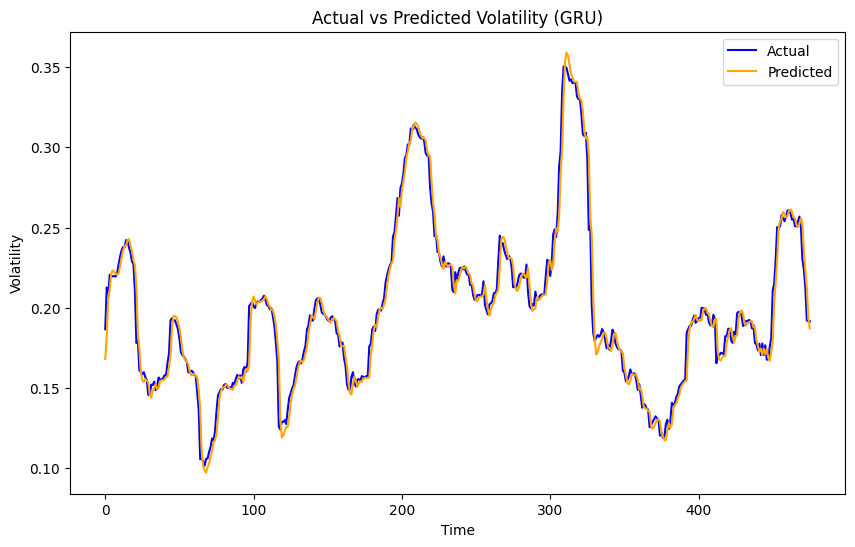

In [9]:
#Now evaluate performance metrics of the model and visualize the results
#start with rescaling data back to original scale
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions back to original values
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale y_test back to original values

#Now lets compute those performance metrics
rmse = np.sqrt(mean_squared_error(y_test_original, gru_predictions))
mae = mean_absolute_error(y_test_original, gru_predictions)
r2 = r2_score(y_test_original, gru_predictions)
print(f"GRU RMSE: {rmse}")
print(f"GRU MAE: {mae}")
print(f"GRU R²: {r2}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(gru_predictions, label='Predicted', color='orange')
plt.title('Actual vs Predicted Volatility (GRU)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## Summary of GRU
Gated Recurrent Unit is a type of recurrent neural network very similar to LSTM, but slightly simpler and with fewer parameters. It also uses gates to control how much information continues through, but has one less state.

Let's look at how our model did:
- GRU also works very well to predict volatility on our dataset
-  We can see that our mean squared error and mean absolute error come out to less than .01 and get even smaller values than LSTM got, which was already hard to beat
- The R^2 also somehow managed to get better and super close to 1 at 0.974
- Finally, we can then see all of these represented in our graph above showing almost the same graph for the actual and predicted volatilities

Now, let's try out the XGboost model

In [ ]:
#Start off with some preprocessing of the data for XGBoost
#This is not an RNN, so we have to change things up a bit

#Starting off with the lagged features function which shifts the data by a certain number of days
def create_lagged_features(data, lag=30):
    df = pd.DataFrame(data, columns=['volatility'])
    for i in range(1, lag+1):
        df[f'lag_{i}'] = df['volatility'].shift(i)
    df.dropna(inplace=True)
    return df

lag = 30 #number of lagged days
data = create_lagged_features(avg_volatility, lag=lag)
#split into features and target
X = data.drop(columns=['volatility']).values
y = data['volatility'].values


#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

#scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

      volatility
20      0.239757
21      0.240327
22      0.239723
23      0.237366
24      0.235685
...          ...
2542    0.223830
2543    0.212225
2544    0.192045
2545    0.191438
2546    0.191474

[2527 rows x 1 columns]
[[0.19883367 0.19633732 0.19057032 ... 0.23972288 0.24032721 0.23975662]
 [0.2022776  0.19883367 0.19633732 ... 0.23736639 0.23972288 0.24032721]
 [0.20002665 0.2022776  0.19883367 ... 0.23568507 0.23736639 0.23972288]
 ...
 [0.21222473 0.22382964 0.23042565 ... 0.17653957 0.17049931 0.17762673]
 [0.19204466 0.21222473 0.22382964 ... 0.16754193 0.17653957 0.17049931]
 [0.19143802 0.19204466 0.21222473 ... 0.16789889 0.16754193 0.17653957]]


In [6]:
#Now our data is ready and we can actually build our XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100, #number of trees
    learning_rate=0.1, #step size shrinkage
    max_depth=5, #max depth of a tree
    subsample=0.8, #fraction of samples used for training each tree
    colsample_bytree=0.8, #Fraction of features used for training each tree
    random_state=42
)

#train the model
xgb_model.fit(X_train, y_train)

#make predictions
xgb_predictions = xgb_model.predict(X_test)

XGBoost RMSE: 0.007942789338512224
XGBoost MAE: 0.005274234747090826
XGBoost R²: 0.974413900149338


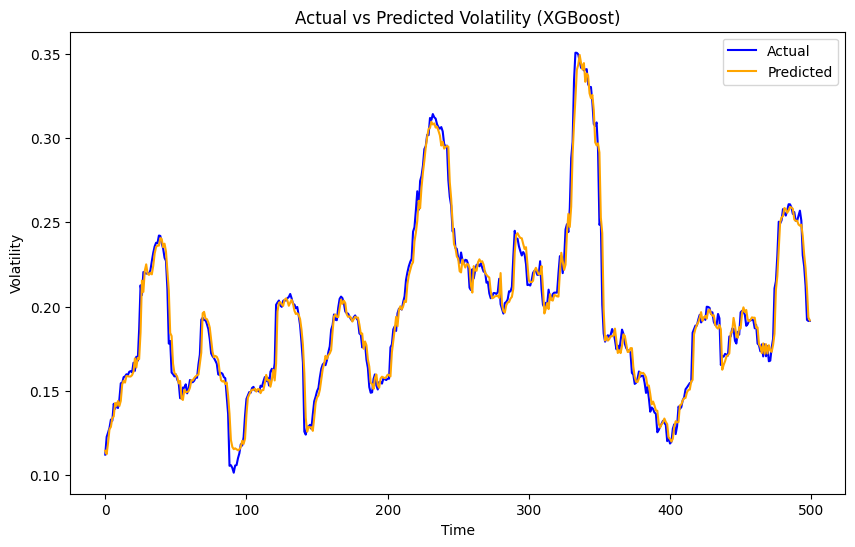

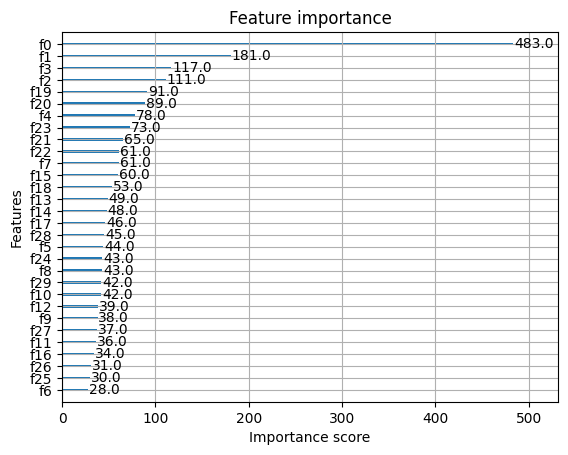

In [29]:
#Now we can evaluate the model performance and visualize results
#rescale first back to original values

#start with metrics
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
mae = mean_absolute_error(y_test, xgb_predictions)
r2 = r2_score(y_test, xgb_predictions)
print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost MAE: {mae}")
print(f"XGBoost R²: {r2}")

#now plot actual v predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(xgb_predictions, label='Predicted', color='orange')
plt.title('Actual vs Predicted Volatility (XGBoost)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

#last checker is to plot feature importance for xgboost
plot_importance(xgb_model, importance_type="weight")
plt.show()

# Summary of XGBoost
An ensemble learning method that builds multiple models and combines them to make a strong predictor. Uses Gradient Boosting comining gradient descent and Boosting with regularization to improve prediction by sequentially adding new trees that correct the errors of the previous ones.

Let's look at how our model did:
- XGBoost also works very well to predict volatility on our dataset and every time you run this model there is no variation or possible margin of difference between runs
-  This seems to be our best model yet with consistent values and a way faster runtime
- RMSE and MAE are better than LSTM and GRU at .008 and .005 respectively
- The R^2 is about the same as GRU at 0.974
- Finally, we can then see all of these represented above and almost an identical graph for the actual and predicted volatilities

When looking at the feature importance, we can also learn some important things
- each feature represents a lagged volatility, so it is the volatility from one day before each point
- so f0 for day 50 is the volatility from day 49, or f30 for day 50 is volatility from day 20
- as we can see in the feature importance graph, the most important feature by far is the day before's volatility measure
- the next 3 are the next 3 days before, it seems to be a trend that makes sense that the closest day's volatility affects the next day the most
- ...but after that it kind goes random and seems to have no followable trend
- We can definitely see though that the first 4 days have a large impact on predicting the volatility 